In [1]:
pip install yfinance numpy pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  10 of 10 completed


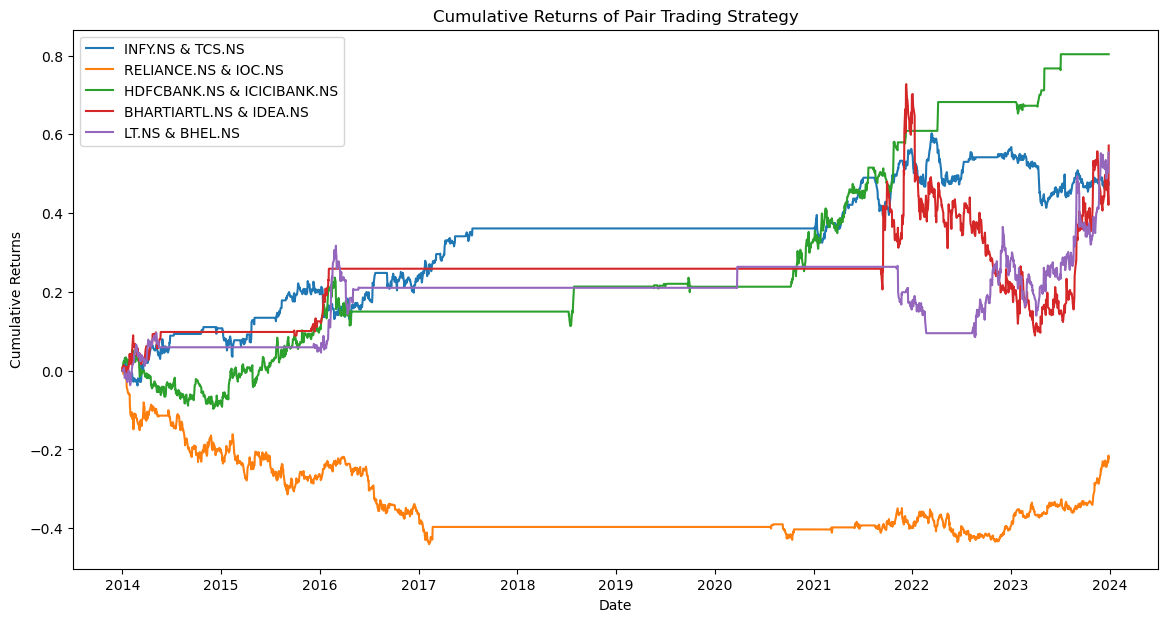

[*********************100%%**********************]  8 of 8 completed


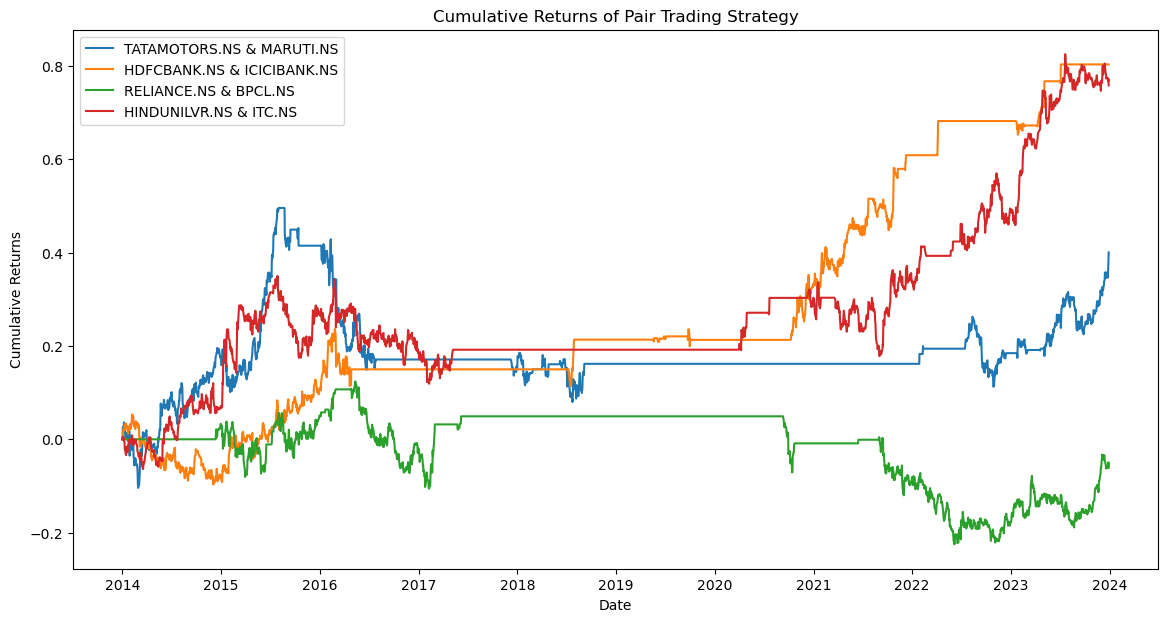

[*********************100%%**********************]  10 of 10 completed


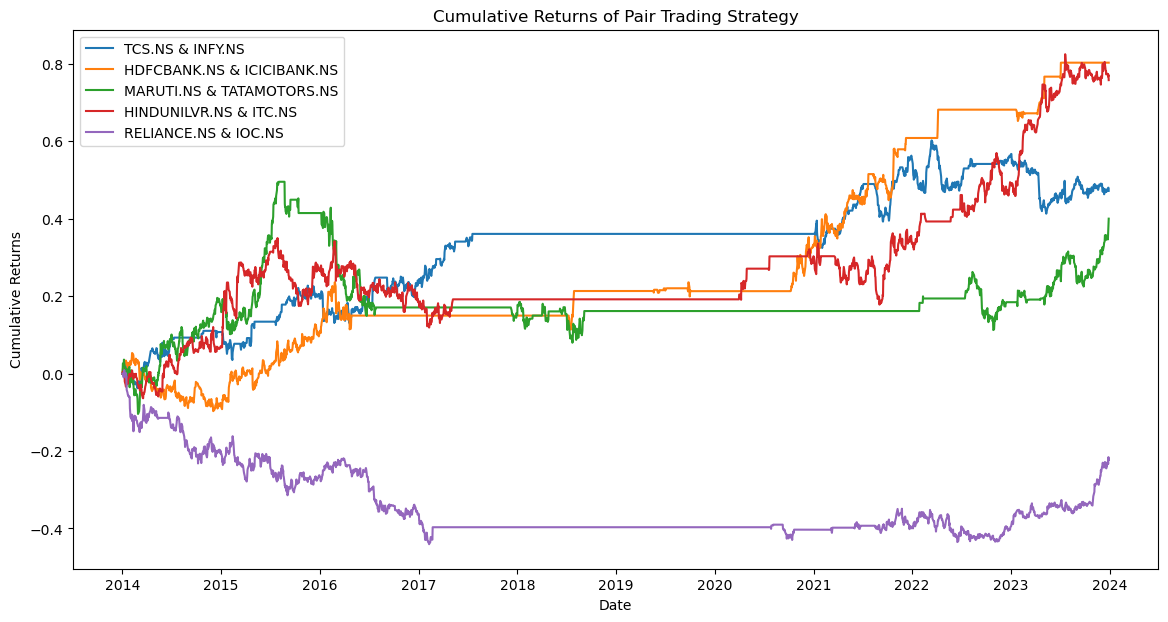

Claude Results:
   Cumulative Returns  Sharpe Ratio  Annualized Sharpe Ratio  \
0            0.472290      0.036313                 0.576458   
1           -0.222604     -0.010780                -0.171131   
2            0.803328      0.048864                 0.775692   
3            0.571481      0.025268                 0.401113   
4            0.554155      0.032830                 0.521165   
5            0.435730      0.026499                 0.420660   

   Maximum Drawdown  Annualized Returns                         Pair  
0         -0.189356            0.043129            (INFY.NS, TCS.NS)  
1         -0.449846           -0.019165        (RELIANCE.NS, IOC.NS)  
2         -0.150183            0.065701  (HDFCBANK.NS, ICICIBANK.NS)  
3         -0.638215            0.057203     (BHARTIARTL.NS, IDEA.NS)  
4         -0.232151            0.050833             (LT.NS, BHEL.NS)  
5         -0.331950            0.039540                      Average  
Mistral Results:
   Cumulative Returns

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate performance metrics
def calculate_metrics(returns):
    cumulative_returns = (1 + returns).cumprod() - 1
    sharpe_ratio = returns.mean() / returns.std()
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)
    drawdown = cumulative_returns - cumulative_returns.cummax()
    max_drawdown = drawdown.min()
    annualized_returns = (1 + returns.mean()) ** 252 - 1

    return {
        "Cumulative Returns": cumulative_returns.iloc[-1],
        "Sharpe Ratio": sharpe_ratio,
        "Annualized Sharpe Ratio": annualized_sharpe_ratio,
        "Maximum Drawdown": max_drawdown,
        "Annualized Returns": annualized_returns
    }

# Function to perform pair trading strategy backtest
def pair_trading_backtest(pairs, start_date="2014-01-01", end_date="2023-12-31"):
    tickers = set([ticker for pair in pairs for ticker in pair])
    data = yf.download(list(tickers), start=start_date, end=end_date)['Adj Close']
    
    # Calculate daily returns
    returns = data.pct_change().dropna()
    
    pair_metrics = []
    cumulative_returns_list = []

    for stock1, stock2 in pairs:
        # Calculate the spread
        spread = data[stock1] - data[stock2]
        
        # Calculate z-score of the spread
        zscore = (spread - spread.mean()) / spread.std()
        
        # Generate trading signals
        long_signals = zscore < -1
        short_signals = zscore > 1
        exit_signals = abs(zscore) < 0.5
        
        # Initialize positions
        positions = pd.DataFrame(index=data.index)
        positions[stock1] = 0
        positions[stock2] = 0
        
        # Create positions
        positions.loc[long_signals, stock1] = 1
        positions.loc[long_signals, stock2] = -1
        positions.loc[short_signals, stock1] = -1
        positions.loc[short_signals, stock2] = 1
        
        # Close positions
        positions.loc[exit_signals, stock1] = 0
        positions.loc[exit_signals, stock2] = 0
        
        # Forward fill positions
        positions = positions.fillna(method='ffill')
        
        # Calculate daily returns of the strategy
        daily_returns = (positions.shift(1) * returns).sum(axis=1)
        
        # Assuming Rs 100 total investment equally distributed
        daily_returns = daily_returns / 2
        
        # Calculate performance metrics
        metrics = calculate_metrics(daily_returns)
        metrics['Pair'] = (stock1, stock2)
        pair_metrics.append(metrics)
        cumulative_returns_list.append((1 + daily_returns).cumprod() - 1)
    
    # Create DataFrame to display results
    results_df = pd.DataFrame(pair_metrics)
    
    # Calculate average metrics, excluding the 'Pair' column
    avg_metrics = results_df.drop(columns=['Pair']).mean().to_dict()
    avg_metrics['Pair'] = 'Average'
    avg_metrics_df = pd.DataFrame([avg_metrics])
    results_df = pd.concat([results_df, avg_metrics_df], ignore_index=True)

    # Plot cumulative returns for each pair
    plt.figure(figsize=(14, 7))
    for i, cumulative_returns in enumerate(cumulative_returns_list):
        pair = pairs[i]
        plt.plot(cumulative_returns, label=f'{pair[0]} & {pair[1]}')
    
    plt.title('Cumulative Returns of Pair Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
    
    return results_df

# Define pairs for each group
claude_pairs = [
    ('INFY.NS', 'TCS.NS'),
    ('RELIANCE.NS', 'IOC.NS'),
    ('HDFCBANK.NS', 'ICICIBANK.NS'),
    ('BHARTIARTL.NS', 'IDEA.NS'),
    ('LT.NS', 'BHEL.NS')
]

mistral_pairs = [
    ('TATAMOTORS.NS', 'MARUTI.NS'),
    ('HDFCBANK.NS', 'ICICIBANK.NS'),
    ('RELIANCE.NS', 'BPCL.NS'),
    ('HINDUNILVR.NS', 'ITC.NS')
]

chatgpt_pairs = [
    ('TCS.NS', 'INFY.NS'),
    ('HDFCBANK.NS', 'ICICIBANK.NS'),
    ('MARUTI.NS', 'TATAMOTORS.NS'),
    ('HINDUNILVR.NS', 'ITC.NS'),
    ('RELIANCE.NS', 'IOC.NS')
]

# Run backtest for each group
claude_results = pair_trading_backtest(claude_pairs)
mistral_results = pair_trading_backtest(mistral_pairs)
chatgpt_results = pair_trading_backtest(chatgpt_pairs)

# Display results
print("Claude Results:")
print(claude_results)

print("Mistral Results:")
print(mistral_results)

print("ChatGPT Results:")
print(chatgpt_results)
